In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

obj_dir = Path("..").resolve() / "bcc" / "libbpf-tools" / ".output"

In [3]:
from depsurf import parse_structs

parse_structs(obj_dir / "bindsnoop.bpf.o")

[bpftool.py:29] INFO: /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.btf already exists
[bpftool.py:47] INFO: /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.h already exists
[bpftool.py:47] INFO: /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.txt already exists
[bpftool.py:47] INFO: /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.json already exists
[normalize.py:148] INFO: /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.jsonl already exists
[normalize.py:149] INFO: /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.pkl already exists
[btf.py:38] INFO: Loading /Users/szhong/Downloads/bpf-study/bcc/libbpf-tools/.output/bindsnoop.bpf.pkl


['in6_addr', 'sock', 'socket', 'sock_common', 'inet_sock']

In [4]:
from depsurf import parse_hooks

parse_hooks(obj_dir / "bindsnoop.bpf.o")

{('kprobe', 'inet6_bind'), ('kprobe', 'inet_bind')}

In [5]:
result = {}

import logging

logging.disable(logging.INFO)

for obj_file in sorted(obj_dir.glob("*.bpf.o")):
    hooks = parse_hooks(obj_file)
    structs = parse_structs(obj_file)
    result[obj_file.name.removesuffix(".bpf.o")] = (hooks, structs)

result.keys()

logging.disable(logging.NOTSET)

In [6]:
from depsurf import KernelImages, get_all_x86_paths

imgs = KernelImages(get_all_x86_paths())

[btf.py:38] INFO: Loading /Users/szhong/Downloads/bpf-study/btf/data/16.04-x86/btf/4.4.0-210-generic.pkl


[btf.py:38] INFO: Loading /Users/szhong/Downloads/bpf-study/btf/data/16.04-x86/btf/4.8.0-58-generic.pkl
[btf.py:38] INFO: Loading /Users/szhong/Downloads/bpf-study/btf/data/16.04-x86/btf/4.10.0-42-generic.pkl
[btf.py:38] INFO: Loading /Users/szhong/Downloads/bpf-study/btf/data/16.04-x86/btf/4.13.0-45-generic.pkl
[btf.py:38] INFO: Loading /Users/szhong/Downloads/bpf-study/btf/data/18.04-x86/btf/4.15.0-213-generic.pkl
[btf.py:38] INFO: Loading /Users/szhong/Downloads/bpf-study/btf/data/18.04-x86/btf/4.18.0-25-generic.pkl
[btf.py:38] INFO: Loading /Users/szhong/Downloads/bpf-study/btf/data/18.04-x86/btf/5.0.0-65-generic.pkl
[btf.py:38] INFO: Loading /Users/szhong/Downloads/bpf-study/btf/data/18.04-x86/btf/5.3.0-76-generic.pkl
[btf.py:38] INFO: Loading /Users/szhong/Downloads/bpf-study/btf/data/18.04-x86/btf/5.4.0-150-generic.pkl
[btf.py:38] INFO: Loading /Users/szhong/Downloads/bpf-study/btf/data/20.04-x86/btf/5.4.0-170-generic.pkl
[btf.py:38] INFO: Loading /Users/szhong/Downloads/bpf-stu

In [7]:
from depsurf import Kind

print(imgs.get_changes(Kind.STRUCT, "inet_sock"))
print(imgs.get_changes(Kind.FUNC, "blk_account_io_start"))

[('4.4', '4.8', [<StructChange.LAYOUT: 'Layout changed'>]), ('4.8', '4.10', [<StructChange.LAYOUT: 'Layout changed'>]), ('4.10', '4.13', [<StructChange.ADD: 'Field added'>, <StructChange.LAYOUT: 'Layout changed'>]), ('4.13', '4.15', [<StructChange.LAYOUT: 'Layout changed'>]), ('4.15', '4.18', [<StructChange.LAYOUT: 'Layout changed'>]), ('4.18', '5.0', [<StructChange.LAYOUT: 'Layout changed'>]), ('5.0', '5.3', [<StructChange.LAYOUT: 'Layout changed'>]), ('5.3', '5.4', [<StructChange.LAYOUT: 'Layout changed'>]), ('5.4', '5.4', [<StructChange.LAYOUT: 'Layout changed'>]), ('5.4', '5.8', [<StructChange.LAYOUT: 'Layout changed'>]), ('5.8', '5.11', [<StructChange.ADD: 'Field added'>, <StructChange.LAYOUT: 'Layout changed'>]), ('5.11', '5.13', [<StructChange.REMOVE: 'Field removed'>, <StructChange.LAYOUT: 'Layout changed'>]), ('5.13', '5.15', [<StructChange.LAYOUT: 'Layout changed'>]), ('5.15', '5.19', [<StructChange.LAYOUT: 'Layout changed'>]), ('5.19', '6.2', [<StructChange.ADD: 'Field added

In [8]:
print(imgs.get_versions(Kind.STRUCT, "renamedata"))
print(imgs.get_versions(Kind.FUNC, "do_page_cache_ra"))

['5.13', '5.15', '5.19', '6.2', '6.5']
['5.11', '5.13', '5.15']


In [9]:
import pickle

with open("subroutine_info.pkl", "rb") as f:
    subroutine_info = pickle.load(f)

In [10]:
subroutine_info["do_execve"]

defaultdict(depsurf.dwarf.traverser.SubroutineEntry,
            {'do_execve': SubroutineEntry(external=True, caller_inline=['__arm64_sys_execve'], caller_func=['run_init_process', 'call_usermodehelper_exec_async'])})

In [11]:
# from depsurf import reload_depsurf

# reload_depsurf()


from depsurf import Scorer, Causes


total_causes = Causes()

scores = []
for name, (hooks, structs) in result.items():
    print(name)
    scorer = Scorer(imgs, subroutine_info)
    causes = scorer.get_stable_score(hooks, structs)
    score = causes.print(nindent=1)
    scores.append(
        {
            "name": name,
            "score": score,
            "hooks": len(hooks),
            "structs": len(structs),
        }
    )
    total_causes.merge(causes)
    print()


total_causes.print()

bashreadline
	uprobe: readline
	Score: 0.00

bindsnoop
	kprobe: inet6_bind
		Non-static Function: ✅
		No callers inlined: ✅
			Callers: []
		Available versions: ✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅ (17/17 = 100%)
		Changes: None
	kprobe: inet_bind
		Non-static Function: ✅
		No callers inlined: ✅
			Callers: []
		Available versions: ✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅ (17/17 = 100%)
		Changes: None
	struct: in6_addr
		Available versions: ✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅ (17/17 = 100%)
		Changes: None
	struct: sock
		Available versions: ✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅✅ (17/17 = 100%)
		Unchanged (1/16 = 6%):
			💥 4.4   -> 4.8  : ['Field added', 'Field removed', 'Field type changed']
			💥 4.8   -> 4.10 : ['Field added']
			💥 4.10  -> 4.13 : ['Field added', 'Field type changed']
			💥 4.13  -> 4.15 : ['Field added', 'Field removed']
			💥 4.15  -> 4.18 : ['Field added', 'Field removed']
			💥 4.18  -> 5.0  : ['Field added', 'Field type changed']
			💥 5.0   -> 5.3  : ['Field added']
			💥 5.3   -> 5.4  : ['Field added']
			💥 5.4   -> 5.4  : ['Field added']
			

4055.8235294117644

In [28]:
import pandas as pd

from depsurf import category_map

df = pd.DataFrame(scores)
df = df.sort_values("score", ascending=False)
df["category"] = df.name.map(lambda x: category_map[x].value)
df = df[df.score > 0]
df

,name,score,hooks,structs,category
6,biotop,207.882353,7,3,block dev
4,biosnoop,201.294118,6,3,block dev
5,biostacks,199.529412,5,3,block dev
2,biolatency,184.882353,3,3,block dev
7,bitesize,171.294118,1,3,block dev
49,tcprtt,162.000000,1,6,network
53,tcptracer,153.000000,5,6,network
37,runqlen,152.000000,1,4,cpu
32,oomkill,134.588235,1,3,memory
48,tcppktlat,130.470588,3,7,network


Text(0.5, 1.0, 'Unstable Score of BPF Programs (lower is better)')

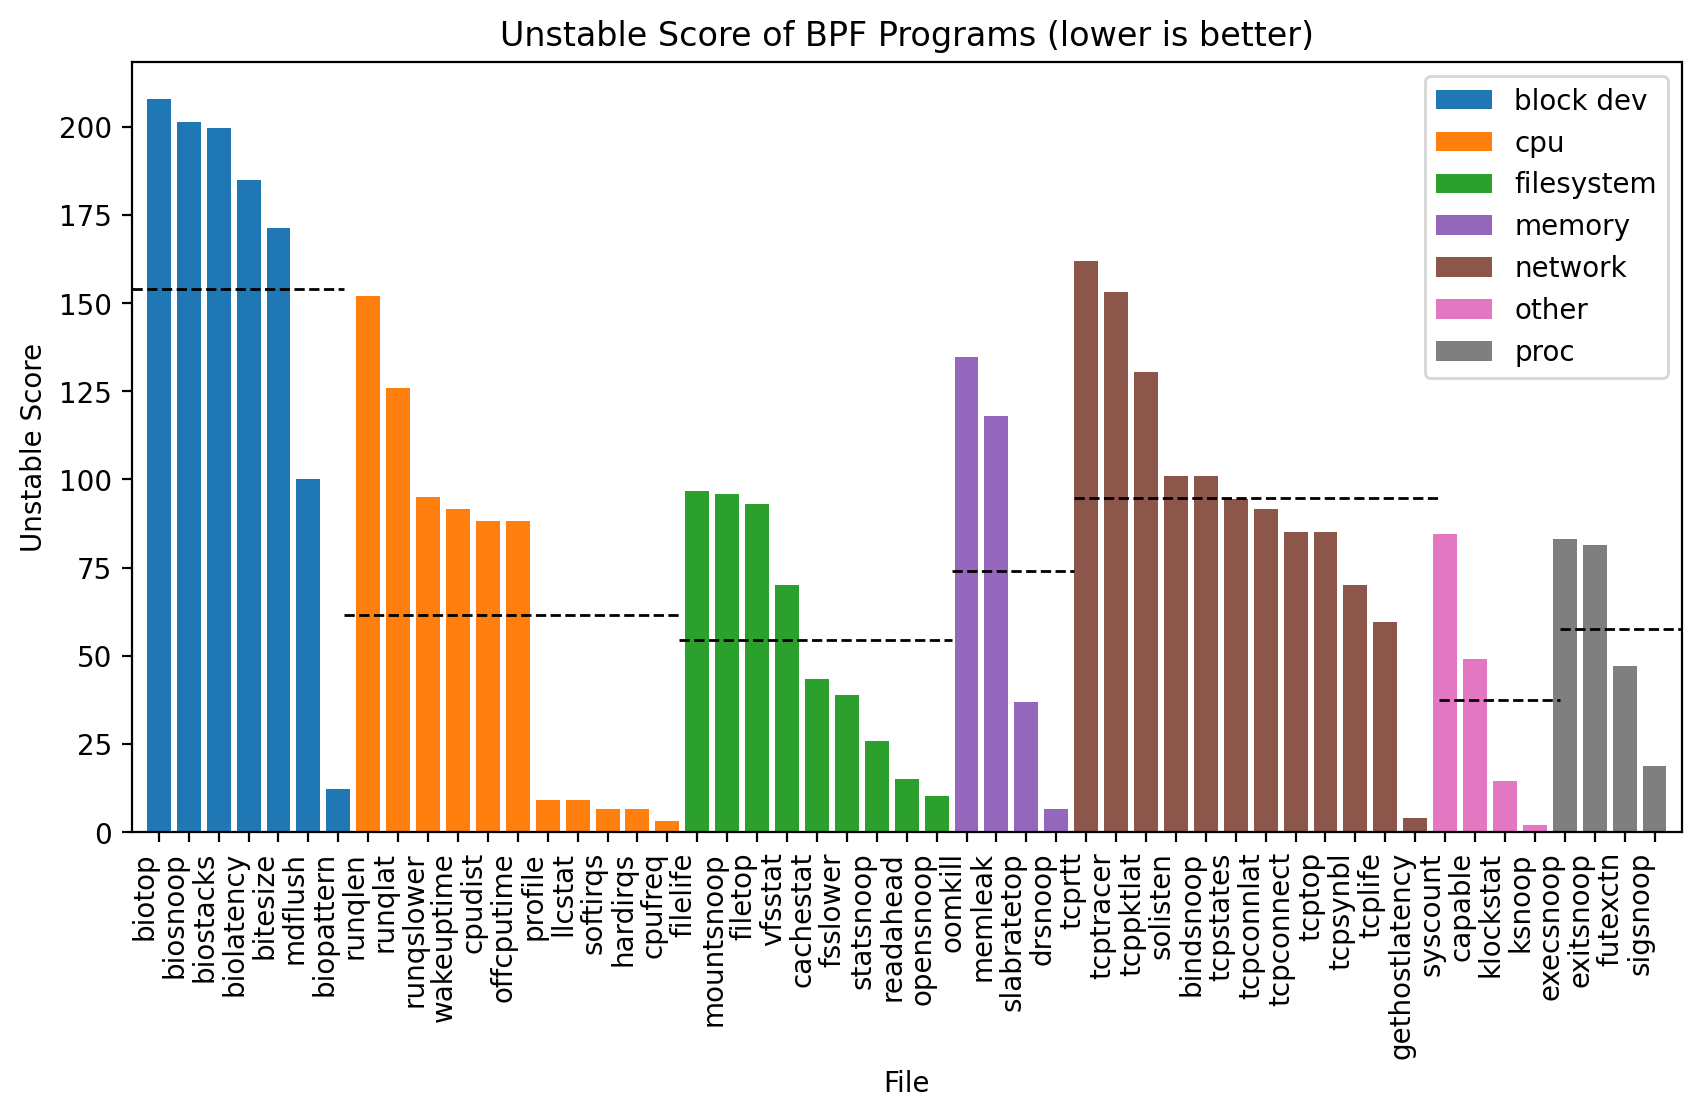

In [53]:
import matplotlib.pyplot as plt
from depsurf import Category

fig, ax = plt.subplots(figsize=(10, 5), dpi=200)

# remove margin for the bar plot
plt.margins(x=0.01)

curr_x = 0
for category, cat_df in df.groupby("category"):
    color = Category(category).color
    ax.bar(cat_df.name, cat_df["score"], color=color, label=category)
    xlen = len(cat_df) / len(df)
    ax.axhline(cat_df["score"].mean(), linestyle="--", xmin=curr_x, xmax=curr_x + xlen, color="black", linewidth=1)
    curr_x += xlen



handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

for label in ax.get_xticklabels():
    label.set_rotation(90)
    label.set_horizontalalignment("right")

ax.set_ylabel("Unstable Score")
ax.set_xlabel("File")
ax.set_title("Unstable Score of BPF Programs (lower is better)")